# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [8]:
print(class_size.head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

# Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [11]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [12]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [14]:
column_names = combined.columns
print(column_names[0:20])
print(column_names[20:40])
print(column_names[40:])

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Demographic', 'School Name', 'Cohort', 'Total Cohort',
       'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads'],
      dtype='object')
Index(['Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
survey_corr = combined[survey_fields].corrwith(combined["sat_score"])

In [17]:
survey_corr = survey_corr.sort_values()
print(survey_corr.index.values, survey_corr.values)

['com_p_11' 'rr_t' 'eng_p_11' 'aca_p_11' 'eng_t_11' 'rr_p' 'com_tot_11'
 'com_t_11' 'eng_tot_11' 'saf_p_11' 'aca_t_11' 'com_s_11' 'aca_tot_11'
 'eng_s_11' 'rr_s' 'N_t' 'saf_t_11' 'saf_tot_11' 'saf_s_11' 'aca_s_11'
 'N_p' 'N_s'] [-0.11507348 -0.02338629  0.02025411  0.03515462  0.03690648  0.04792452
  0.0773102   0.08241942  0.10010183  0.12291284  0.13234767  0.1873702
  0.19096598  0.21382161  0.23219913  0.29146303  0.31381033  0.31875345
  0.33763874  0.33943547  0.42153003  0.42346295]


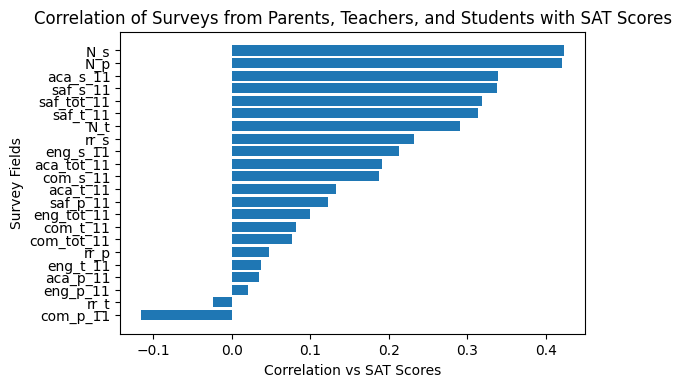

In [18]:

plt.barh(survey_corr.index.values, survey_corr.values)
plt.xlabel("Correlation vs SAT Scores")
plt.ylabel("Survey Fields")
plt.title("Correlation of Surveys from Parents, Teachers, and Students with SAT Scores")
plt.show()

The most significant correlations are the number of student and parent respondents (N_s, N_p), student academic expectations (aca_s) and the sense of safety and respect by students and teachers (saf_s, saf_tot, saf_t)

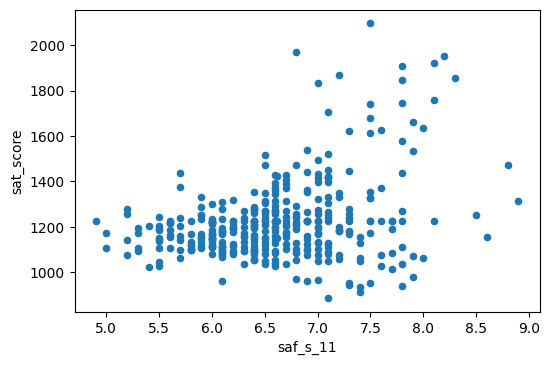

In [19]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There appears to be a positive correlation when the safety score is > 7, but overall there is not a strong correlation.

In [20]:
def get_borough(DBN):
    return DBN[2]
combined["Borough"] = combined["DBN"].str[2]
print(combined["Borough"])

0      M
1      M
2      M
3      M
4      M
      ..
358    K
359    K
360    K
361    K
362    K
Name: Borough, Length: 363, dtype: object


In [21]:
import numpy as np
safety_cols = ["saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]
safety = combined.groupby("Borough").agg(np.mean)
safety = safety[safety_cols]
print(safety)

         saf_s_11  saf_t_11  saf_p_11  saf_tot_11
Borough                                          
K        6.370755  6.985849  8.036792    7.129245
M        6.831370  7.287778  8.288889    7.473333
Q        6.721875  7.365625  8.098437    7.387500
R        6.530000  7.210000  7.800000    7.200000
X        6.606577  7.026882  8.346237    7.322581


In general the students rated "Safety and Respect" the lowest and parents gave the highest ratings.  There was not a trend among the boroughs, but Brooklyn was rated the lowest safety by the students and teachers but not the parents.  The difference between safety ratings in each borough by each group was less than 8%

In [22]:
race_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
race_corr = combined[race_cols].corrwith(combined["sat_score"])
print(race_corr)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
dtype: float64


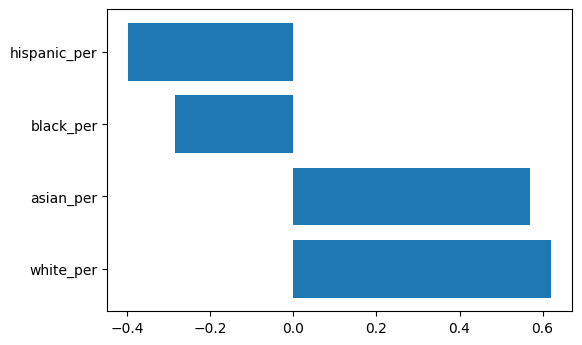

In [23]:
plt.barh(race_corr.index.values, race_corr.values)
plt.show()

There is a positive correlation above 0.5 for white and asian people.  There is a negative correlation for hispanic and black people.

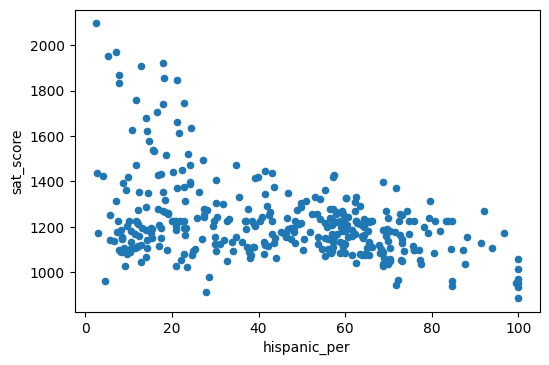

In [24]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.show()

The scatterplot shows a negative correlation between sat_scores and the percent of hispanics in the school.  A school with 100% hispanics scored lower on the SAT than schools that had a smaller percentage of hispanics.

In [25]:
hispanic_schools = combined[combined["hispanic_per"] > 95]["School Name"]
print(hispanic_schools)

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


These are schools that have 90% economically disadvantaged individuals who are also minorities

In [26]:
low_hispanic_schools = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["School Name"]
print(low_hispanic_schools)

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


These high schools are specialized for academically gifted students

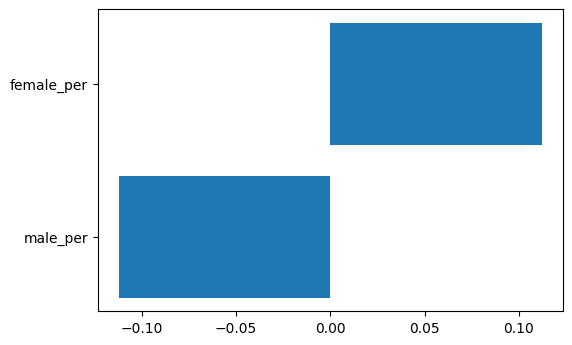

In [30]:
gender_cols = ["male_per", "female_per"]
gender_corr = combined[gender_cols].corrwith(combined["sat_score"])
plt.barh(gender_corr.index.values, gender_corr.values)
plt.show()

There is a small correlation betweeen female percentage and male percentage vs SAT scores.  It is a positive correlation for females and a negative correlation for males.

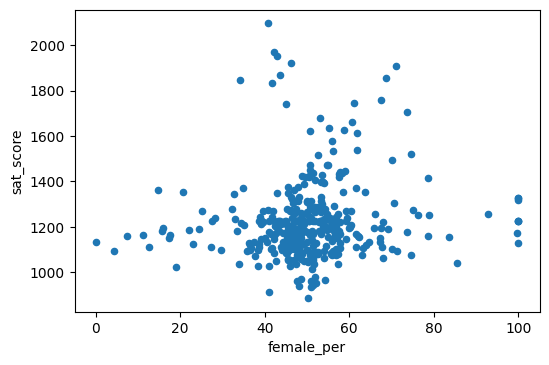

In [31]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

There is not a correlation between the percent female and SAT scores

In [33]:
high_score_female = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["School Name"]
print(high_score_female)

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


All of these schools are more focused on a liberal education.  They are also competetive to get into.

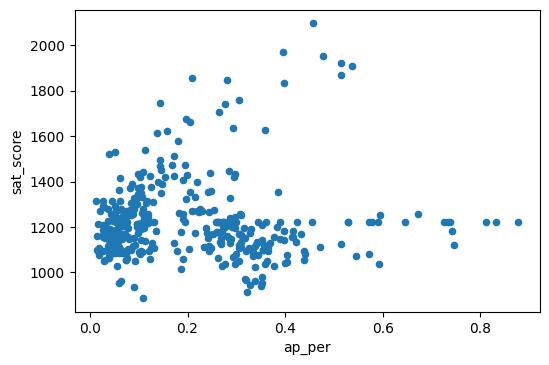

In [35]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")
plt.show()

There is a bimodal correlation where there are some schools that had a strong correlaton between ap_per and SAT scores and other set of 